In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import rioxarray as rio

import pandas as pd
from pathlib import Path
from pystac_client import Client
import folium

from src.utils import SentinelDownloader

root = Path.cwd()

In [2]:
pts = gpd.read_file(root / 'beech_stands' / 'Points.shp' )
pts = pts.to_crs(26918)
# remove first 4 rows
pts2 = pts.loc[4:,]

# make separate species and dbh columns
pts2['species'] = [x[0] for x in pts2.Name.str.split('dbh')]
pts2['dbh'] = [x[-1] for x in pts2.Name.str.split('dbh')]
pts2 = pts2.drop('Name',axis=1)

# make separate beech and nonbeech gdf
pts2['species'] = pts2.species.str.strip()
beech_pts = pts2.loc[pts2.species=='beech']
beech_pts.shape
beech_pts['index'] = np.arange(0,len(beech_pts))

nonbeech_pts = pts2.loc[pts2.species!='beech']
nonbeech_pts.shape
nonbeech_pts = nonbeech_pts.reset_index()

# define 100m buffers for each cluster of pointss
pecoy_buffer = beech_pts.iloc[27:28,].buffer(100)
roundtop_buffer = beech_pts.iloc[54:55,].buffer(100)
visitors_buffer = beech_pts.iloc[66:67,].buffer(100)

c:\Users\roseh\miniconda3\envs\beech-env\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\roseh\miniconda3\envs\beech-env\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Users\roseh\miniconda3\envs\beech-env\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [3]:
polys = gpd.read_file(root / 'beech_stands' / 'Beech Stand Polygons.kml')
polys = polys.reset_index()

In [5]:
# choose point to serve as map center coordinates
map_coords = tuple(beech_pts.to_crs(4326).get_coordinates().iloc[37,]) # get xy coords for index 37
map_coords = tuple([map_coords[1],map_coords[0]]) # switch them around because everything is integrated seamlessly

# define 100m buffers for each cluster of pointss
pecoy_buffer = beech_pts.iloc[27:28,].buffer(100)
roundtop_buffer = beech_pts.iloc[54:55,].buffer(100)
visitors_buffer = beech_pts.iloc[66:67,].buffer(100)

s = pd.concat([pecoy_buffer,roundtop_buffer,visitors_buffer])

# plot results
m = folium.Map(location=map_coords, zoom_start=11)

folium.GeoJson(
    beech_pts.to_crs(4326),
    marker=folium.Circle(radius=2, fill_color="orange", fill_opacity=0.4, color="orange", weight=1),
    tooltip=folium.GeoJsonTooltip(fields=["index","species"])
).add_to(m)

folium.GeoJson(
    nonbeech_pts.to_crs(4326),
    marker=folium.Circle(radius=2, fill_color="red", fill_opacity=0.4, color="red", weight=1),
    tooltip=folium.GeoJsonTooltip(fields=["index","species"])
).add_to(m)

# add buffers to map
# folium.GeoJson(
#     s.to_crs(4326)
# ).add_to(m)

folium.GeoJson(
    polys,
    style_function=lambda x:{
         "fillColor": "red"
        if x['properties']["Name"] == 'non-beech stand'
        else "orange",
        "color":"red"
        if x['properties']["Name"] == 'non-beech stand'
        else "orange"},
    tooltip=folium.GeoJsonTooltip(fields=["Name","index"])
).add_to(m)

m

In [31]:
m.save(root / 'figures' / 'catskills.html')

In [ ]:
rt = SentinelDownloader(2023,roundtop_buffer,epsg=26918)
rt.missing_data = [1,9,20,26,27,28]
rt.drop_missing_data()
rt.get_indices()
rt.save_vi_data(root,'2023_roundtop')

number of low cloud images: 37


In [ ]:
# download and inspect Pecoy data
pc = SentinelDownloader(2023,pecoy_buffer,epsg=26918)
pc.plot_initial_data()

In [ ]:
# filter out dates with missing data
pc.missing_data = [1,9,19,20,26,28]
pc.drop_missing_data()
pc.plot_complete_data()

In [16]:
# calculate indices and save
pc.get_indices()
pc.save_vi_data(root,'2023_pecoy')

In [ ]:
# download and inspect visitors data
vs = SentinelDownloader(2023,visitors_buffer,epsg=26918)
vs.plot_initial_data()

In [18]:
# filter out missing data, calculate indices and save
vs.missing_data = [19,22,26,27]
vs.drop_missing_data()
vs.get_indices()
vs.save_vi_data(root,'2023_visitors')

### Plot points/polygons overlaid with Sentinel data

C:\Users\roseh\AppData\Local\Temp\ipykernel_13688\2680353202.py:6: UserWarning: The indices of the left and right GeoSeries' are not equal, and therefore they will be aligned (reordering and/or introducing missing values) before executing the operation. If this alignment is the desired behaviour, you can silence this warning by passing 'align=True'. If you don't want alignment and protect yourself of accidentally aligning, you can pass 'align=False'.
  p = beech_pts.within(roundtop_buffer)


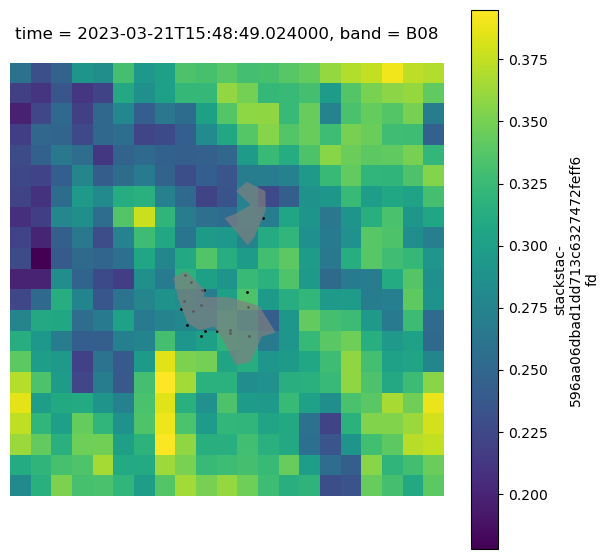

In [ ]:
# select trees within roundtop buffer
points_idx = roundtop_buffer.sindex.query(beech_pts.geometry, predicate="intersects")[0]
roundtop_trees = beech_pts.iloc[points_idx]

# select polygons at roundtop location
rt_polys = polys.iloc[[0,5],:]
rt_polys = rt_polys.to_crs(26918)

# read in roundtop sentinel data
img = xr.open_dataarray(root / 'sentinel_data' / '2023_roundtop.nc')

# plot trees overlaid with sentinel data
fig, ax = plt.subplots(ncols=1, figsize=(7, 7))

im = img.isel(band=6,time=5)
#img = xr.apply_ufunc(exposure.rescale_intensity, img)
p = beech_pts.within(roundtop_buffer)

im.plot.imshow(ax=ax)
roundtop_trees.plot(ax=ax,color='black',markersize=1)
rt_polys.plot(ax=ax,color='grey',alpha=0.7)



ax.set_axis_off()